## Assignment 2 ##

Author: Joshua Vieira

### Data Preprocessing ###
Before training our perceptrons, we need to process the Simpson's MNIST data.

In [62]:
from PIL import Image
import numpy as np
import os
import copy

#This is for reproducibility, it ensures our weights initialization, and shuffle when shuffling the np arrays remain the same with this fixed seed.
np.random.seed(10)

In [63]:
def load_data(base_path="rgb"):
    """
    Loads the rgb Simpson's MNIST dataset, using a default base name "rgb",
    which contains the train and test folders.
    Returns numpy arrays for training and test images, their labels, and the classes.
    """
    def load_split(file_name):
        classes = os.listdir(file_name)
        images = []
        labels = []
        for i, character in enumerate(classes):
            class_path = os.path.join(file_name, character)
            for img_index in os.listdir(class_path):
                img_path = os.path.join(class_path, img_index)
                img = np.array(Image.open(img_path))
                images.append(img)
                labels.append(i)
        return np.array(images), np.array(labels), classes

    # training set
    train_path = os.path.join(base_path, "train")
    rgb_training, labels_training, classes = load_split(train_path)

    # test set
    test_path = os.path.join(base_path, "test")
    rgb_test, labels_test, _ = load_split(test_path)

    return rgb_training, labels_training, rgb_test, labels_test, classes


In [64]:
#Testing the loading of our data
images_rgb, labels_rgb, rgb_test, labels_test, classes_rgb = load_data()
images_grayscale, _, gray_test, _, classes_grayscale = load_data("grayscale") #The labels are the same in both rgb
#and grayscale, so we can just ignore the grayscale labels

print(images_rgb.shape, images_grayscale.shape)
print(rgb_test.shape, gray_test.shape)
print(labels_rgb.shape, labels_test.shape)
print(classes_rgb, classes_grayscale)

(8000, 28, 28, 3) (8000, 28, 28)
(2000, 28, 28, 3) (2000, 28, 28)
(8000,) (2000,)
['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner'] ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']


Our data loaded correctly and with the correct dimensions, now we must split the training data into a training and validation set, we already have the test sets.

We will split the training and validation in an **90/10** split.
We will also normalize the data after splitting.

In [65]:
def normalize(X, method="minmax"):
    """
    Normalizes the np array using either minmax normalization or gaussian, default is set to minmax.
    Returns the normalized array.
    """
    if method == "minmax":
        X_norm = X / 255.0
    if method == "gaussian":
        X_norm = (X - X.mean(axis = 0))/X.std(axis = 0)
    
    return X_norm

In [66]:
indices = np.arange(len(images_rgb))  #Shuffle randomly the images so we dont miss the last characters
np.random.shuffle(indices)

images_rgb = images_rgb[indices]
labels_rgb = labels_rgb[indices] 
images_grayscale = images_grayscale[indices]  #Keep rbg and grayscale and the labels in the same order or aligned

#Now flatten and normalize
rgb_flatten = normalize(images_rgb.reshape(images_rgb.shape[0], -1), method="gaussian")
gray_flatten = normalize(images_grayscale.reshape(images_grayscale.shape[0], -1), method="gaussian")
rgb_test_flatten = normalize(rgb_test.reshape(rgb_test.shape[0], -1), method="gaussian")
gray_test_flatten = normalize(gray_test.reshape(gray_test.shape[0], -1), method="gaussian")

#Now split into train/valid
train_end = int(0.9 * len(rgb_flatten))
rgb_train, rgb_val = rgb_flatten[:train_end], rgb_flatten[train_end:]
gray_train, gray_val = gray_flatten[:train_end], gray_flatten[train_end:]
y_train, y_val = labels_rgb[:train_end], labels_rgb[train_end:]

### Binary Perceptron ###
We will be making the single binary perceptron class.

In [67]:
class Perceptron:
    """
    Perceptron with learnable weights and bias, 
    initialized to zero and updated using the perceptron learning rule.
    """
    def __init__(self, n_inputs, alpha=0.1, initialization_strategy = "zero"):
        if initialization_strategy == "zero":
            self.weights = np.zeros(n_inputs)
            self.initialization_strategy = "zero"
        if initialization_strategy == "constant":
            self.weights = np.full(n_inputs, 0.01)
            self.initialization_strategy = "constant"
        if initialization_strategy == "uniform":
            self.weights = np.random.uniform(-0.1, 0.1, n_inputs)
            self.initialization_strategy = "uniform"
        if initialization_strategy == "gaussian":
            self.weights = np.random.normal(0, 0.01, n_inputs)
            self.initialization_strategy = "gaussian"
        self.bias = 0
        self.alpha = alpha

    def forward(self, x):
        """
        Returns the score, we dont need the activation, 1 or 0 because the multiclass will take the highest value.
        """
        return np.dot(self.weights, x) + self.bias
    
    def learning_rule(self, x, y):
        """
        Applies the perceptron learning rule.
        Returns the new weights and bias.
        We are assuming that the vectors x and y are already numpy arrays.
        """
        score = self.forward(x)
        y_predicted = 1 if score >= 0 else 0    
        self.weights += self.alpha * (y - y_predicted) * x
        self.bias += self.alpha * (y - y_predicted)
        
    def __repr__(self):
        """
        This is like the toString() function in java, just to see our object and its state.
        """
        return f"TrainablePerceptron(weights={self.weights}, bias={self.bias:.3f}, alpha={self.alpha}, initialization strategy={self})"

### Multiclass Perceptron ###
This class will be the one we actually use, the multiclass perceptron will use one-vs-rest classification.

In [68]:
class MultiClassPerceptron:
    """
    Uses 10 binary perceptrons to implement one-vs-rest classification
    """
    def __init__(self, num_inputs, alpha=0.1, num_perceptrons=10, initialization_strategy = "zero"):
        self.perceptrons = [Perceptron(num_inputs, alpha=alpha, initialization_strategy=initialization_strategy) for _ in range(num_perceptrons)]
    
    def multi_learning_rule(self, x, label):
        """
        Applies the perceptron learning rule to every perceptron in our multiclass classifier.
        We need to know which class each perceptron is for, so we assign the respective perceptron's target to 1
        if it is the matching class, otherwise the target is 0. This will make more sense once we show the actual training and 
        how the label feeds in.
        """
        for class_id, percep in enumerate(self.perceptrons):
            target = 1 if class_id == label else 0
            percep.learning_rule(x, target)

    def predict(self, x):
        """
        According to one-vs-rest classification, we take the most confident perceptron, i.e. the one with the highest score.
        """
        return np.argmax([percep.forward(x) for percep in self.perceptrons])
        

### Training ###
We will train 2 models, one on the RGB Simpsons and the other on the Grayscale Simpsons. However, we must first define an evaluate method that returns the accuracy.

We will also use 2 stopping criteria, max iterations or epochs, and if an accuracy improvement is not seen for 10 epochs.

In [69]:
def accuracy(multi_perceptron, X, Y):
    correct = 0
    for x, y in zip(X, Y):
        y_prediction = multi_perceptron.predict(x)
        if y_prediction == y:
            correct += 1
    a = correct/X.shape[0]
    return a



In [70]:
multi_p_rgb_temp = MultiClassPerceptron(rgb_train.shape[1], alpha=0.01, initialization_strategy="gaussian")

max_accuracy = 0
counter = 0

for epoch in range(100):
    idxs = np.arange(len(rgb_train))
    np.random.shuffle(idxs)
    for i in idxs:  # iterate in shuffled order, this should give us higher accuracy
        x, y = rgb_train[i], y_train[i]
        multi_p_rgb_temp.multi_learning_rule(x, y)

    eval = accuracy(multi_p_rgb_temp, rgb_val, y_val)#Our accuracy
    print(f"Epoch: {epoch + 1}, accuracy = {eval}")

    if eval > max_accuracy:
        max_accuracy = eval
        counter = 0
        multi_p_rgb = copy.deepcopy(multi_p_rgb_temp)
    else:
        counter += 1

    if counter >= 10:
        print(f"Early stopping at epoch {epoch + 1}, accuracy = {max_accuracy}")
        break
    

Epoch: 1, accuracy = 0.28875
Epoch: 2, accuracy = 0.36625
Epoch: 3, accuracy = 0.37125
Epoch: 4, accuracy = 0.37
Epoch: 5, accuracy = 0.36
Epoch: 6, accuracy = 0.38875
Epoch: 7, accuracy = 0.37875
Epoch: 8, accuracy = 0.405
Epoch: 9, accuracy = 0.41
Epoch: 10, accuracy = 0.40375
Epoch: 11, accuracy = 0.4
Epoch: 12, accuracy = 0.4075
Epoch: 13, accuracy = 0.4125
Epoch: 14, accuracy = 0.415
Epoch: 15, accuracy = 0.41875
Epoch: 16, accuracy = 0.40375
Epoch: 17, accuracy = 0.34125
Epoch: 18, accuracy = 0.37625
Epoch: 19, accuracy = 0.3825
Epoch: 20, accuracy = 0.4225
Epoch: 21, accuracy = 0.39
Epoch: 22, accuracy = 0.38625
Epoch: 23, accuracy = 0.3975
Epoch: 24, accuracy = 0.3925
Epoch: 25, accuracy = 0.39625
Epoch: 26, accuracy = 0.41
Epoch: 27, accuracy = 0.41625
Epoch: 28, accuracy = 0.4125
Epoch: 29, accuracy = 0.41625
Epoch: 30, accuracy = 0.44
Epoch: 31, accuracy = 0.4025
Epoch: 32, accuracy = 0.4225
Epoch: 33, accuracy = 0.41375
Epoch: 34, accuracy = 0.42875
Epoch: 35, accuracy = 0.

In [71]:
#Now the same but with the grayscale
multi_p_gray_temp = MultiClassPerceptron(gray_train.shape[1], alpha=0.01, initialization_strategy="gaussian")

max_accuracy = 0
counter = 0

for epoch in range(100):
    idxs = np.arange(len(gray_train))
    np.random.shuffle(idxs)
    for i in idxs:
        x, y = gray_train[i], y_train[i]
        multi_p_gray_temp.multi_learning_rule(x, y)

    eval = accuracy(multi_p_gray_temp, gray_val, y_val)
    print(f"Epoch: {epoch + 1}, accuracy = {eval}")

    if eval > max_accuracy:
        max_accuracy = eval
        counter = 0
        multi_p_gray = copy.deepcopy(multi_p_gray_temp)
    else:
        counter += 1

    if counter >= 10:
        print(f"Early stopping at epoch {epoch + 1}, accuracy = {max_accuracy}")
        break
    


Epoch: 1, accuracy = 0.18375
Epoch: 2, accuracy = 0.2025
Epoch: 3, accuracy = 0.22875
Epoch: 4, accuracy = 0.20625
Epoch: 5, accuracy = 0.22875
Epoch: 6, accuracy = 0.19875
Epoch: 7, accuracy = 0.2275
Epoch: 8, accuracy = 0.22375
Epoch: 9, accuracy = 0.2175
Epoch: 10, accuracy = 0.2175
Epoch: 11, accuracy = 0.23875
Epoch: 12, accuracy = 0.19125
Epoch: 13, accuracy = 0.205
Epoch: 14, accuracy = 0.23
Epoch: 15, accuracy = 0.22375
Epoch: 16, accuracy = 0.2425
Epoch: 17, accuracy = 0.2425
Epoch: 18, accuracy = 0.2325
Epoch: 19, accuracy = 0.22625
Epoch: 20, accuracy = 0.225
Epoch: 21, accuracy = 0.23625
Epoch: 22, accuracy = 0.19625
Epoch: 23, accuracy = 0.24
Epoch: 24, accuracy = 0.25875
Epoch: 25, accuracy = 0.22875
Epoch: 26, accuracy = 0.23625
Epoch: 27, accuracy = 0.255
Epoch: 28, accuracy = 0.2325
Epoch: 29, accuracy = 0.21125
Epoch: 30, accuracy = 0.235
Epoch: 31, accuracy = 0.25375
Epoch: 32, accuracy = 0.2175
Epoch: 33, accuracy = 0.23875
Epoch: 34, accuracy = 0.23125
Early stoppi

### Hyperparameter Tuning ###
We will implement a grid search on a range of hyperparameters and the values of them to find the optimal combination that gets
the highest accuracy.

In [72]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
init_strategies = ["zero", "constant", "uniform", "gaussian"]
normalization_techniques = ["minmax", "gaussian", None]

combination_rgb = []

for lr in learning_rates:
    for inits in init_strategies:
        for normal in normalization_techniques:
            print(f"\nCombination: lr={lr}, init={inits}, norm={normal}")
            
            if normal is not None:
                rgb_flatten = normalize(images_rgb.reshape(images_rgb.shape[0], -1), method=normal)
            else:
                rgb_flatten = images_rgb.reshape(images_rgb.shape[0], -1)

            rgb_train, rgb_val = rgb_flatten[:train_end], rgb_flatten[train_end:]

            model = MultiClassPerceptron(rgb_train.shape[1], lr, 10, inits)

            max_accuracy = 0.0
            best_model = None
            counter = 0

            for epoch in range(100):
                idxs = np.arange(len(rgb_train))
                np.random.shuffle(idxs)

                for i in idxs:
                    x, y = rgb_train[i], y_train[i]
                    model.multi_learning_rule(x, y)

                eval = accuracy(model, rgb_val, y_val)

                if eval > max_accuracy:
                    max_accuracy = eval
                    best_model = copy.deepcopy(model)
                    counter = 0
                else:
                    counter += 1

                if counter >= 10:
                    print(f"Early stopping at epoch {epoch+1}, accuracy = {max_accuracy:.3f}")
                    break

            combination_rgb.append({
            "learning rate": lr,
            "initialization strategy": inits,
            "normalization technique": normal,
            "accuracy": max_accuracy,
            "model": best_model,
            "train_data": rgb_train,
            "val_data": rgb_val
            })


Combination: lr=0.0001, init=zero, norm=minmax
Early stopping at epoch 23, accuracy = 0.465

Combination: lr=0.0001, init=zero, norm=gaussian
Early stopping at epoch 30, accuracy = 0.454

Combination: lr=0.0001, init=zero, norm=None
Early stopping at epoch 12, accuracy = 0.421

Combination: lr=0.0001, init=constant, norm=minmax
Early stopping at epoch 40, accuracy = 0.474

Combination: lr=0.0001, init=constant, norm=gaussian
Early stopping at epoch 25, accuracy = 0.455

Combination: lr=0.0001, init=constant, norm=None
Early stopping at epoch 25, accuracy = 0.432

Combination: lr=0.0001, init=uniform, norm=minmax
Early stopping at epoch 52, accuracy = 0.367

Combination: lr=0.0001, init=uniform, norm=gaussian
Early stopping at epoch 29, accuracy = 0.415

Combination: lr=0.0001, init=uniform, norm=None
Early stopping at epoch 29, accuracy = 0.454

Combination: lr=0.0001, init=gaussian, norm=minmax
Early stopping at epoch 31, accuracy = 0.446

Combination: lr=0.0001, init=gaussian, norm=

In [73]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
init_strategies = ["zero", "constant", "uniform", "gaussian"]
normalization_techniques = ["minmax", "gaussian", None]

combination_gray = []

for lr in learning_rates:
    for inits in init_strategies:
        for normal in normalization_techniques:
            print(f"\nCombination: lr={lr}, init={inits}, norm={normal}")
            
            if normal is not None:
                gray_flatten = normalize(images_grayscale.reshape(images_grayscale.shape[0], -1), method=normal)
            else:
                gray_flatten = images_grayscale.reshape(images_grayscale.shape[0], -1)

            gray_train, gray_val = gray_flatten[:train_end], gray_flatten[train_end:]

            model = MultiClassPerceptron(gray_train.shape[1], lr, 10, inits)

            max_accuracy = 0.0
            best_model = None
            counter = 0

            for epoch in range(100):
                idxs = np.arange(len(gray_train))
                np.random.shuffle(idxs)

                for i in idxs:
                    x, y = gray_train[i], y_train[i]
                    model.multi_learning_rule(x, y)

                eval = accuracy(model, gray_val, y_val)

                if eval > max_accuracy:
                    max_accuracy = eval
                    best_model = copy.deepcopy(model)
                    counter = 0
                else:
                    counter += 1

                if counter >= 10:
                    print(f"Early stopping at epoch {epoch+1}, accuracy = {max_accuracy:.3f}")
                    break

            combination_gray.append({
            "learning rate": lr,
            "initialization strategy": inits,
            "normalization technique": normal,
            "accuracy": max_accuracy,
            "model": best_model,
            "train_data": gray_train, 
            "val_data": gray_val  
            })


Combination: lr=0.0001, init=zero, norm=minmax
Early stopping at epoch 12, accuracy = 0.242

Combination: lr=0.0001, init=zero, norm=gaussian
Early stopping at epoch 26, accuracy = 0.265

Combination: lr=0.0001, init=zero, norm=None
Early stopping at epoch 22, accuracy = 0.250

Combination: lr=0.0001, init=constant, norm=minmax
Early stopping at epoch 28, accuracy = 0.287

Combination: lr=0.0001, init=constant, norm=gaussian
Early stopping at epoch 16, accuracy = 0.245

Combination: lr=0.0001, init=constant, norm=None
Early stopping at epoch 23, accuracy = 0.233

Combination: lr=0.0001, init=uniform, norm=minmax
Early stopping at epoch 33, accuracy = 0.211

Combination: lr=0.0001, init=uniform, norm=gaussian
Early stopping at epoch 59, accuracy = 0.244

Combination: lr=0.0001, init=uniform, norm=None
Early stopping at epoch 38, accuracy = 0.256

Combination: lr=0.0001, init=gaussian, norm=minmax
Early stopping at epoch 44, accuracy = 0.261

Combination: lr=0.0001, init=gaussian, norm=

Now we get the three combinations with the highest max accuracy values in the grid search.

In [74]:
top3_rgb = sorted(combination_rgb, key=lambda x: x["accuracy"], reverse=True)[:3]
top3_gray = sorted(combination_gray, key=lambda x: x["accuracy"], reverse=True)[:3]

for i, comb in enumerate(top3_rgb, 1):
    print(f"RGB Top {i}: LR={comb['learning rate']}, Init={comb['initialization strategy']}, "f"Norm={comb['normalization technique']}, Accuracy={comb['accuracy']:.4f}")

for i, comb in enumerate(top3_gray, 1):
        print(f"Grayscale Top {i}: LR={comb['learning rate']}, Init={comb['initialization strategy']}, "f"Norm={comb['normalization technique']}, Accuracy={comb['accuracy']:.4f}")


RGB Top 1: LR=0.1, Init=uniform, Norm=minmax, Accuracy=0.4888
RGB Top 2: LR=0.0001, Init=constant, Norm=minmax, Accuracy=0.4738
RGB Top 3: LR=0.1, Init=constant, Norm=None, Accuracy=0.4738
Grayscale Top 1: LR=0.0001, Init=constant, Norm=minmax, Accuracy=0.2875
Grayscale Top 2: LR=0.1, Init=uniform, Norm=minmax, Accuracy=0.2762
Grayscale Top 3: LR=0.01, Init=uniform, Norm=minmax, Accuracy=0.2725


In [75]:
best_rgb_combination = max(combination_rgb, key=lambda x: x["accuracy"])
final_rgb_model = copy.deepcopy(best_rgb_combination["model"])
rgb_val_final = best_rgb_combination["val_data"]

print("RGB accuracy:", accuracy(final_rgb_model, rgb_val_final, y_val))

best_gray_combination = max(combination_gray, key=lambda x: x["accuracy"])
final_gray_model = copy.deepcopy(best_gray_combination["model"])
gray_val_final = best_gray_combination["val_data"]

print("Grayscale accuracy:", accuracy(final_gray_model, gray_val_final, y_val))


RGB accuracy: 0.48875
Grayscale accuracy: 0.2875


The combination that yields the highest accuracy for rgb is:

RGB Top 1: LR=0.1, Init=uniform, Norm=minmax, Accuracy=0.4888

For grayscale:

Grayscale Top 1: LR=0.0001, Init=constant, Norm=minmax, Accuracy=0.2875

### Evaluation ###
We will be Evaluating our rgb and grayscale models with the optimal hyperparameters on both the validation and test sets using 4 metrics, accuracy; precision; recall and the F1 score. 
In addition to evaluating the model on the whole validation and test set, we will also evaluate it on a per class basis.
This will help us see which characters our model struggles identifying.

We need to make functions to calculate and return the precision, recall and F1 score. We have already made the overall model accuracy function.

In [76]:
def accuracy_per_class(model, X, Y, classes):
    accuracies = {}
    predictions = [model.predict(x) for x in X]

    for class_id, class_name in enumerate(classes):
        num_correct = sum((pred == class_id) and (true == class_id) for pred, true in zip(predictions, Y))
        total = sum((true == class_id) for true in Y)

        accuracies[class_name] = num_correct/total

    return accuracies

In [77]:
def precision(model, X, Y, classes):
    """
    Computes the per class precision in our multiclass classifier.
    params:
        model: our multiclass perceptron
        X: the dataset
        Y: the labels
        classes: characters corresponding to each label, e.g. 0 is Bart Simpson
    """
    precisions = {}
    predictions = [model.predict(x) for x in X]

    for class_id, class_name in enumerate(classes):
        true_positives = sum((pred == class_id) and (true == class_id) for pred, true in zip(predictions, Y))
        false_positives = sum((pred == class_id) and (true != class_id) for pred, true in zip(predictions, Y))

        precisions[class_name] = true_positives / (true_positives + false_positives)

    return precisions



In [78]:
def overall_precision(model, X, Y, classes):
    """
    Returns the overall precision of the model
    params:
        model: our multiclass perceptron
        X: the dataset
        Y: the labels
        classes: characters corresponding to each label, e.g. 0 is Bart Simpson
    """
    return np.mean(list(precision(model, X, Y, classes).values()))

In [79]:
def recall(model, X, Y, classes):
    """
    Computes the per class recall of our model
    params:
        model: the multiclass perceptron
        X: the dataset
        Y: the labels
        classes: the characters that correspond to the labels
    """
    recalls = {}
    predictions = [model.predict(x) for x in X]

    for class_id, class_name in enumerate(classes):
        true_positives = sum((pred == class_id) and (true == class_id) for pred, true in zip(predictions, Y))
        false_negatives = sum((pred != class_id) and (true == class_id) for pred, true in zip(predictions, Y))

        recalls[class_name] = true_positives / (true_positives + false_negatives)
    
    return recalls


In [80]:
def overall_recall(model, X, Y, classes):
    """
    Returns the overall recall of the model
    params:
        model: the multiclass perceptron
        X: the dataset
        Y: the labels
        classes: the characters that correspond to the labels
    """
    return np.mean(list(recall(model, X, Y, classes).values()))

In [81]:
def F1_score(model, X, Y, classes):
    """
    Returns the F1 Score of the model on a per class basis
    params:
        model: the multiclass perceptron
        X: the dataset
        Y: the labels
        classes: the characters that correspond to the labels
    """
    rec = recall(model, X, Y, classes)
    prec = precision(model, X, Y, classes)

    f1_scores = {}
    
    for class_name in classes:
        f1_scores[class_name] = 2*rec[class_name]*prec[class_name] / (rec[class_name] + prec[class_name])
    
    return f1_scores

In [82]:
def overall_F1_score(model, X, Y, classes):
    """
    Returns the overall F1 Score of the model
    params:
        model: the multiclass perceptron
        X: the dataset
        Y: the labels
        classes: the characters that correspond to the labels
    """
    return 2*overall_precision(model, X, Y, classes)*overall_recall(model, X, Y, classes) / (overall_precision(model, X, Y, classes)+overall_recall(model, X, Y, classes))

Now we will be computing the per-class and overall evaluation metrics. 

In [83]:
acc = accuracy_per_class(final_rgb_model, rgb_val_final, y_val, classes_rgb)
#Just recall that rgb_test_flatten is the final version of the test set for rgb
acc_test = accuracy_per_class(final_rgb_model, rgb_test_flatten, labels_test, classes_rgb)
acc_overall = accuracy(final_rgb_model, rgb_val_final, y_val)
acc_overall_test = accuracy(final_rgb_model, rgb_test_flatten, labels_test)

# Validation set
print("Validation set per-class accuracy:")
for char, a in acc.items():
    print(f"{char}: {a:.3f}" if a is not None else f"{char}: No samples")

# Test set
print("\nTest set per-class accuracy:")
for char, a in acc_test.items():
    print(f"{char}: {a:.3f}" if a is not None else f"{char}: No samples")

print(f"\nOverall Accuracy on validation set: {acc_overall:.3f}")
print(f"Overall Accuracy on test set {acc_overall_test:.3f}")




Validation set per-class accuracy:
bart_simpson: 0.134
charles_montgomery_burns: 0.456
homer_simpson: 0.313
krusty_the_clown: 0.629
lisa_simpson: 0.425
marge_simpson: 0.869
milhouse_van_houten: 0.532
moe_szyslak: 0.519
ned_flanders: 0.622
principal_skinner: 0.324

Test set per-class accuracy:
bart_simpson: 0.190
charles_montgomery_burns: 0.380
homer_simpson: 0.235
krusty_the_clown: 0.615
lisa_simpson: 0.275
marge_simpson: 0.790
milhouse_van_houten: 0.510
moe_szyslak: 0.390
ned_flanders: 0.485
principal_skinner: 0.445

Overall Accuracy on validation set: 0.489
Overall Accuracy on test set 0.431


In [84]:
#Now for the Precision
prec = precision(final_rgb_model, rgb_val_final, y_val, classes_rgb)
prec_test = precision(final_rgb_model, rgb_test_flatten, labels_test, classes_rgb)
prec_overall = overall_precision(final_rgb_model, rgb_val_final, y_val, classes_rgb)
prec_overall_test = overall_precision(final_rgb_model, rgb_test_flatten, labels_test, classes_rgb)

# Validation set
print("Validation set per-class precision:")
for char, p in prec.items():
    print(f"{char}: {p:.3f}" if p is not None else f"{char}: No predictions")

# Test set
print("\nTest set per-class precision:")
for char, p in prec_test.items():
    print(f"{char}: {p:.3f}" if p is not None else f"{char}: No predictions")

print(f"\nOverall Precision on validation set: {prec_overall:.3f}")
print(f"Overall Precision on test set: {prec_overall_test:.3f}")

Validation set per-class precision:
bart_simpson: 0.440
charles_montgomery_burns: 0.423
homer_simpson: 0.477
krusty_the_clown: 0.489
lisa_simpson: 0.523
marge_simpson: 0.652
milhouse_van_houten: 0.483
moe_szyslak: 0.466
ned_flanders: 0.409
principal_skinner: 0.535

Test set per-class precision:
bart_simpson: 0.309
charles_montgomery_burns: 0.350
homer_simpson: 0.431
krusty_the_clown: 0.469
lisa_simpson: 0.440
marge_simpson: 0.560
milhouse_van_houten: 0.457
moe_szyslak: 0.476
ned_flanders: 0.359
principal_skinner: 0.396

Overall Precision on validation set: 0.490
Overall Precision on test set: 0.425


In [85]:
#Similarly for the recall
rec = recall(final_rgb_model, rgb_val_final, y_val, classes_rgb)
rec_test = recall(final_rgb_model, rgb_test_flatten, labels_test, classes_rgb)
rec_overall = overall_recall(final_rgb_model, rgb_val_final, y_val, classes_rgb)
rec_overall_test = overall_recall(final_rgb_model, rgb_test_flatten, labels_test, classes_rgb)

# Validation set
print("Validation set per-class recall:")
for char, r in rec.items():
    print(f"{char}: {r:.3f}" if r is not None else f"{char}: No predictions")

# Test set
print("\nTest set per-class recall:")
for char, r in rec_test.items():
    print(f"{char}: {r:.3f}" if r is not None else f"{char}: No predictions")

print(f"\nOverall Recall on validation set: {rec_overall:.3f}")
print(f"Overall Recall on test set: {rec_overall_test:.3f}")


Validation set per-class recall:
bart_simpson: 0.134
charles_montgomery_burns: 0.456
homer_simpson: 0.313
krusty_the_clown: 0.629
lisa_simpson: 0.425
marge_simpson: 0.869
milhouse_van_houten: 0.532
moe_szyslak: 0.519
ned_flanders: 0.622
principal_skinner: 0.324

Test set per-class recall:
bart_simpson: 0.190
charles_montgomery_burns: 0.380
homer_simpson: 0.235
krusty_the_clown: 0.615
lisa_simpson: 0.275
marge_simpson: 0.790
milhouse_van_houten: 0.510
moe_szyslak: 0.390
ned_flanders: 0.485
principal_skinner: 0.445

Overall Recall on validation set: 0.482
Overall Recall on test set: 0.431


In [86]:
#And finally for the F1 Score
f1 = F1_score(final_rgb_model, rgb_val_final, y_val, classes_rgb)
f1_test = F1_score(final_rgb_model, rgb_test_flatten, labels_test, classes_rgb)
f1_overall = overall_F1_score(final_rgb_model, rgb_val_final, y_val, classes_rgb)
f1_overall_test = overall_F1_score(final_rgb_model, rgb_test_flatten, labels_test, classes_rgb)

# Validation set
print("Validation set per-class F1-score:")
for char, score in f1.items():
    print(f"{char}: {score:.3f}" if score is not None else f"{char}: No predictions")

# Test set
print("\nTest set per-class F1-score:")
for char, score in f1_test.items():
    print(f"{char}: {score:.3f}" if score is not None else f"{char}: No predictions")

print(f"\nOverall F1-score on validation set: {f1_overall:.3f}")
print(f"Overall F1-score on test set: {f1_overall_test:.3f}")


Validation set per-class F1-score:
bart_simpson: 0.206
charles_montgomery_burns: 0.439
homer_simpson: 0.378
krusty_the_clown: 0.550
lisa_simpson: 0.469
marge_simpson: 0.745
milhouse_van_houten: 0.506
moe_szyslak: 0.491
ned_flanders: 0.494
principal_skinner: 0.404

Test set per-class F1-score:
bart_simpson: 0.235
charles_montgomery_burns: 0.365
homer_simpson: 0.304
krusty_the_clown: 0.532
lisa_simpson: 0.338
marge_simpson: 0.656
milhouse_van_houten: 0.482
moe_szyslak: 0.429
ned_flanders: 0.413
principal_skinner: 0.419

Overall F1-score on validation set: 0.486
Overall F1-score on test set: 0.428


Now we must do the same but with the grayscale data

In [87]:
acc = accuracy_per_class(final_gray_model, gray_val_final, y_val, classes_grayscale)
#Just recall that gray_test_flatten is the final version of the test set for rgb
acc_test = accuracy_per_class(final_gray_model, gray_test_flatten, labels_test, classes_grayscale)
acc_overall = accuracy(final_gray_model, gray_val_final, y_val)
acc_overall_test = accuracy(final_gray_model, gray_test_flatten, labels_test)

# Validation set
print("Validation set per-class accuracy:")
for char, a in acc.items():
    print(f"{char}: {a:.3f}" if a is not None else f"{char}: No samples")

# Test set
print("\nTest set per-class accuracy:")
for char, a in acc_test.items():
    print(f"{char}: {a:.3f}" if a is not None else f"{char}: No samples")

print(f"\nOverall Accuracy on validation set: {acc_overall:.3f}")
print(f"Overall Accuracy on test set {acc_overall_test:.3f}")


Validation set per-class accuracy:
bart_simpson: 0.415
charles_montgomery_burns: 0.478
homer_simpson: 0.134
krusty_the_clown: 0.386
lisa_simpson: 0.150
marge_simpson: 0.119
milhouse_van_houten: 0.380
moe_szyslak: 0.203
ned_flanders: 0.408
principal_skinner: 0.127

Test set per-class accuracy:
bart_simpson: 0.145
charles_montgomery_burns: 0.325
homer_simpson: 0.210
krusty_the_clown: 0.220
lisa_simpson: 0.165
marge_simpson: 0.410
milhouse_van_houten: 0.240
moe_szyslak: 0.270
ned_flanders: 0.365
principal_skinner: 0.245

Overall Accuracy on validation set: 0.287
Overall Accuracy on test set 0.260


In [88]:
prec = precision(final_gray_model, gray_val_final, y_val, classes_grayscale)
prec_test = precision(final_gray_model, gray_test_flatten, labels_test, classes_grayscale)
prec_overall = overall_precision(final_gray_model, gray_val_final, y_val, classes_grayscale)
prec_overall_test = overall_precision(final_gray_model, gray_test_flatten, labels_test, classes_grayscale)

print("Validation set per-class precision:")
for char, p in prec.items():
    print(f"{char}: {p:.3f}" if p is not None else f"{char}: No predictions")

print("\nTest set per-class precision:")
for char, p in prec_test.items():
    print(f"{char}: {p:.3f}" if p is not None else f"{char}: No predictions")

print(f"\nOverall Precision on validation set: {prec_overall:.3f}")
print(f"Overall Precision on test set: {prec_overall_test:.3f}")


Validation set per-class precision:
bart_simpson: 0.221
charles_montgomery_burns: 0.301
homer_simpson: 0.375
krusty_the_clown: 0.225
lisa_simpson: 0.316
marge_simpson: 0.476
milhouse_van_houten: 0.265
moe_szyslak: 0.421
ned_flanders: 0.354
principal_skinner: 0.250

Test set per-class precision:
bart_simpson: 0.274
charles_montgomery_burns: 0.212
homer_simpson: 0.266
krusty_the_clown: 0.223
lisa_simpson: 0.347
marge_simpson: 0.320
milhouse_van_houten: 0.300
moe_szyslak: 0.290
ned_flanders: 0.223
principal_skinner: 0.236

Overall Precision on validation set: 0.320
Overall Precision on test set: 0.269


In [89]:
rec = recall(final_gray_model, gray_val_final, y_val, classes_grayscale)
rec_test = recall(final_gray_model, gray_test_flatten, labels_test, classes_grayscale)
rec_overall = overall_recall(final_gray_model, gray_val_final, y_val, classes_grayscale)
rec_overall_test = overall_recall(final_gray_model, gray_test_flatten, labels_test, classes_grayscale)

print("Validation set per-class recall:")
for char, r in rec.items():
    print(f"{char}: {r:.3f}" if r is not None else f"{char}: No samples")

print("\nTest set per-class recall:")
for char, r in rec_test.items():
    print(f"{char}: {r:.3f}" if r is not None else f"{char}: No samples")

print(f"\nOverall Recall on validation set: {rec_overall:.3f}")
print(f"Overall Recall on test set: {rec_overall_test:.3f}")

Validation set per-class recall:
bart_simpson: 0.415
charles_montgomery_burns: 0.478
homer_simpson: 0.134
krusty_the_clown: 0.386
lisa_simpson: 0.150
marge_simpson: 0.119
milhouse_van_houten: 0.380
moe_szyslak: 0.203
ned_flanders: 0.408
principal_skinner: 0.127

Test set per-class recall:
bart_simpson: 0.145
charles_montgomery_burns: 0.325
homer_simpson: 0.210
krusty_the_clown: 0.220
lisa_simpson: 0.165
marge_simpson: 0.410
milhouse_van_houten: 0.240
moe_szyslak: 0.270
ned_flanders: 0.365
principal_skinner: 0.245

Overall Recall on validation set: 0.280
Overall Recall on test set: 0.259


In [90]:
f1 = F1_score(final_gray_model, gray_val_final, y_val, classes_grayscale)
f1_test = F1_score(final_gray_model, gray_test_flatten, labels_test, classes_grayscale)
f1_overall = overall_F1_score(final_gray_model, gray_val_final, y_val, classes_grayscale)
f1_overall_test = overall_F1_score(final_gray_model, gray_test_flatten, labels_test, classes_grayscale)

print("Validation set per-class F1:")
for char, f in f1.items():
    print(f"{char}: {f:.3f}" if f is not None else f"{char}: No samples")

print("\nTest set per-class F1:")
for char, f in f1_test.items():
    print(f"{char}: {f:.3f}" if f is not None else f"{char}: No samples")

print(f"\nOverall F1 on validation set: {f1_overall:.3f}")
print(f"Overall F1 on test set: {f1_overall_test:.3f}")

Validation set per-class F1:
bart_simpson: 0.288
charles_montgomery_burns: 0.369
homer_simpson: 0.198
krusty_the_clown: 0.284
lisa_simpson: 0.203
marge_simpson: 0.190
milhouse_van_houten: 0.313
moe_szyslak: 0.274
ned_flanders: 0.379
principal_skinner: 0.168

Test set per-class F1:
bart_simpson: 0.190
charles_montgomery_burns: 0.257
homer_simpson: 0.235
krusty_the_clown: 0.222
lisa_simpson: 0.224
marge_simpson: 0.360
milhouse_van_houten: 0.267
moe_szyslak: 0.280
ned_flanders: 0.277
principal_skinner: 0.240

Overall F1 on validation set: 0.299
Overall F1 on test set: 0.264


### Confusion Matrix ###
Below is a visualization of our results and model using scikit's built-in confusion matrix and matplotlib.
This will be done on our validation set. We are going to scale our values in the confusion matrix just so that it gives us a percentage rather than a number, it will be easier to interpret this way.

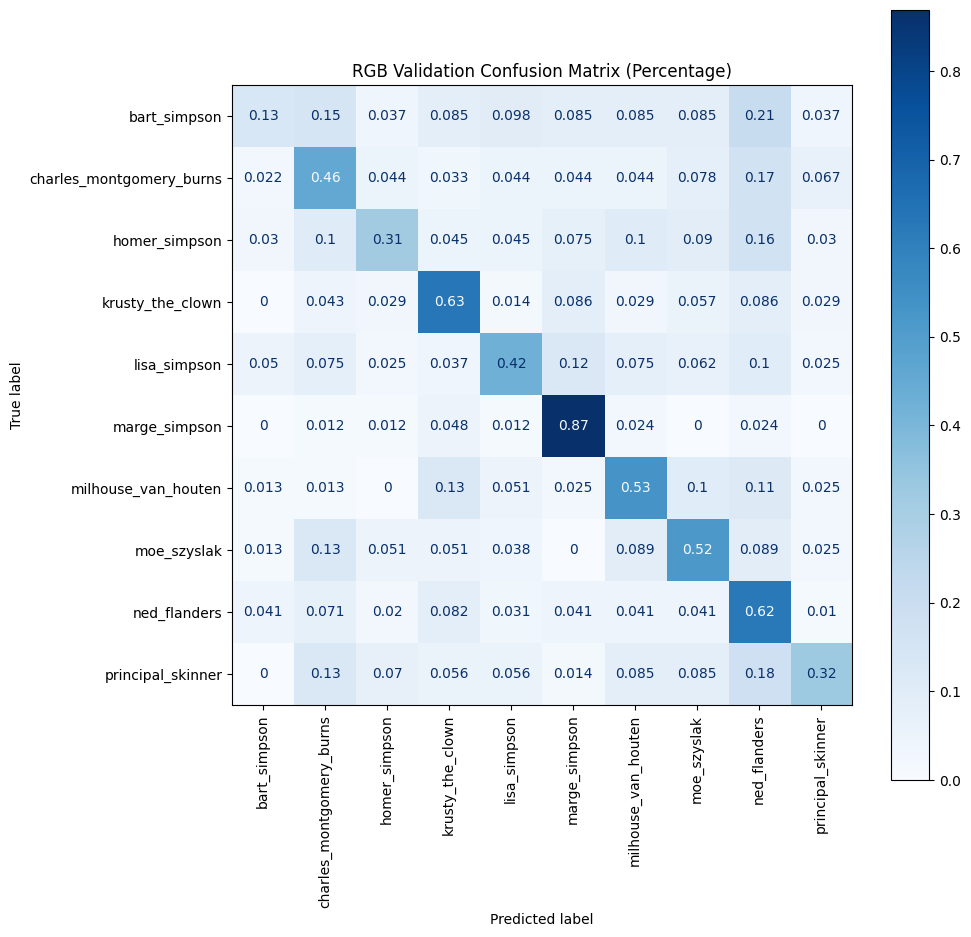

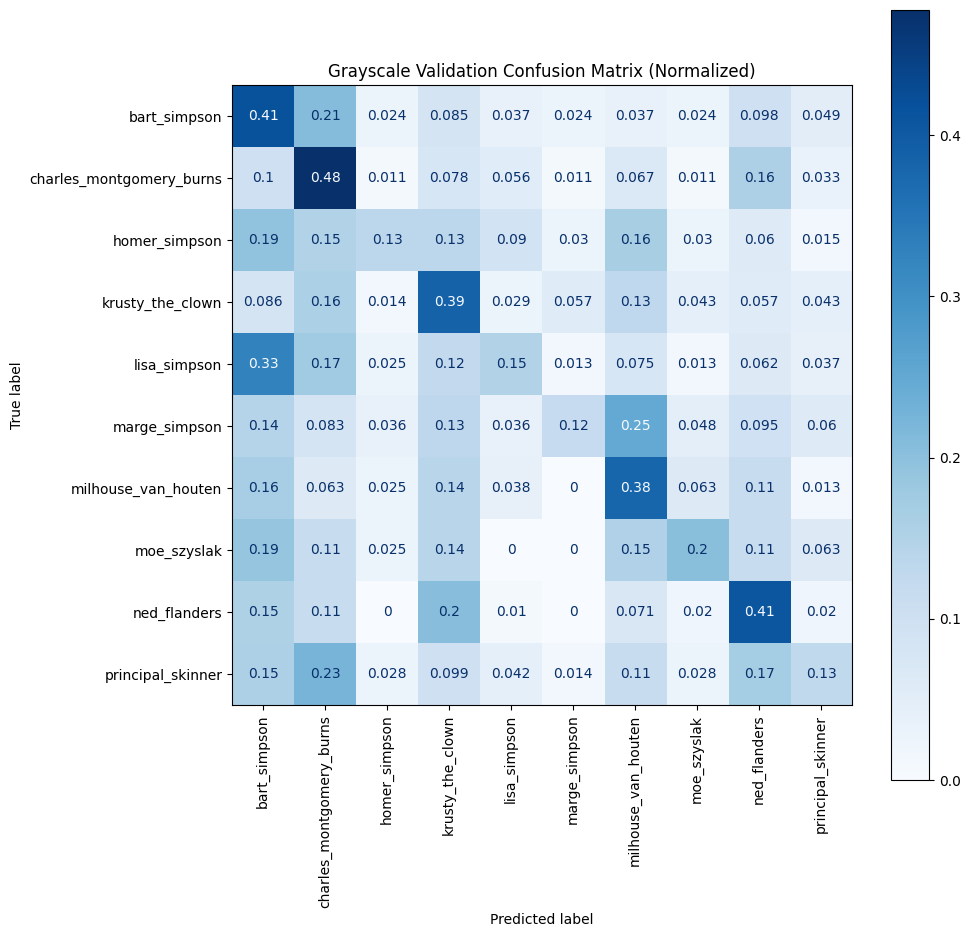

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#rgb
y_val_pred_rgb = [final_rgb_model.predict(x) for x in rgb_val_final]
cm_rgb = confusion_matrix(y_val, y_val_pred_rgb) #We get a 2d numpy array from this

#each row adds to 1 (law of total prob), a character has to be classified as itself or some other character, then divide by the sum of the row
cm_rgb_normalized = cm_rgb.astype('float') / cm_rgb.sum(axis=1)[:, np.newaxis] #Need a new axis for numpy broadcasting otherwise will divide column wise

disp_rgb = ConfusionMatrixDisplay(confusion_matrix=cm_rgb_normalized, display_labels=classes_rgb)
fig, ax = plt.subplots(figsize=(10, 10))
disp_rgb.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation="vertical", colorbar=True)
plt.title("RGB Validation Confusion Matrix (Percentage)")
plt.show()

#grayscale
y_val_pred_gray = [final_gray_model.predict(x) for x in gray_val_final]
cm_gray = confusion_matrix(y_val, y_val_pred_gray)

cm_gray_normalized = cm_gray.astype('float') / cm_gray.sum(axis=1)[:, np.newaxis]

disp_gray = ConfusionMatrixDisplay(confusion_matrix=cm_gray_normalized, display_labels=classes_grayscale)
fig, ax = plt.subplots(figsize=(10, 10))
disp_gray.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation="vertical", colorbar=True)
plt.title("Grayscale Validation Confusion Matrix (Normalized)")
plt.show()
